In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']
    if isinstance(stockData, pd.Series):
        stockData = pd.DataFrame(stockData)
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov() if len(returns.columns) > 1 else returns.var()
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

stockList = ['VOO']
stocks = [stock for stock in stockList]
endDate = dt.datetime.now()
startDate = dt.datetime(2010, 9, 7)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns.dot(weights)

[*********************100%%**********************]  1 of 1 completed


In [3]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 100 days
Time = 100

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return:       508.39
Value at Risk 95th CI    :       1639.45
Conditional VaR 95th CI  :       2628.96


In [4]:
def var_parametric(portfolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portfolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portfolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR.item() 

def cvar_parametric(portfolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portfolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portfolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR.item()  # Convert array to scalar

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       1273.03
Normal CVaR 95th CI      :       1725.58
t-dist VaR 95th CI       :       1209.94
t-dist CVaR 95th CI      :       1826.79


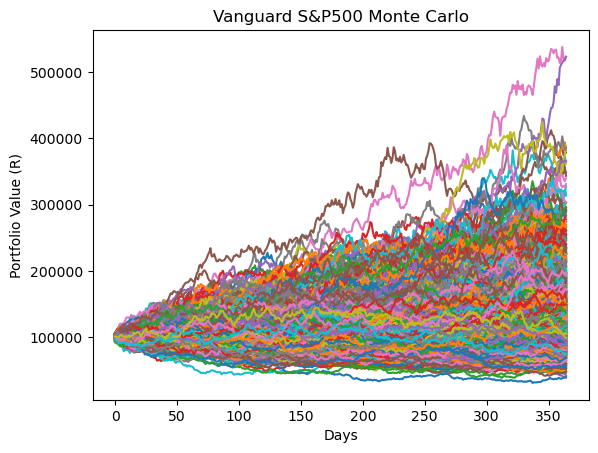

Mean final portfolio value: 119722.28216021032


In [5]:
# Monte Carlo Method
mc_sims = 1000  
T = 365 

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns) 
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

portfolioStd = returns.std(axis=0).values.reshape(-1, 1)

initialPortfolio = 100000

for m in range(mc_sims):
    Z = np.random.normal(size=(T, len(weights)))
    dailyReturns = meanM + Z * portfolioStd.T  
    portfolio_sims[:, m] = np.cumprod(np.sum(weights * dailyReturns, axis=1) + 1) * initialPortfolio

mean_final_value = np.mean(portfolio_sims)

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value (R)')
plt.xlabel('Days')
plt.title('Vanguard S&P500 Monte Carlo')
plt.show()

print("Mean final portfolio value:", mean_final_value)